<h2>Algorithm X</h2>
<ol> 
    <li> Construct a matrix, A with <i>n</i> columns, where <i>n</i> is the sum of the number of elements used to cover the field and the number of cells to be covered - this ensures we have a way of identifying which elements cover which fields - this is not 100% necessary if we're using a single shape only. In our case we do not need to worry about the exact coverage of the elements columns - we are going to use the same shape more than one - only one shape in the most extreme cases.</li>
    <li> Construct rows use to represent all possible valid positions of the covering elements - 1 in the column identifying the piece and 1s in all the columns identifying cells covered by given element.</li>
    <li> Look for solutions that have exaclty one 1 in each column, i.e. each cell is covered by one element only and there are no overlapping elements.</li>
    <ol> 
        <li>If matrix A is empty (all 0s) - problem solved, terminate successfully</li>
        <li>Deterministically choose column, c - chooce column which has the fewest 1s, leading to the lowest number of branches in laters stages of the algorithm</li>
        <li>Nondeterministically chooise a row, r such that A[r, c] = 1 - this is the place where the algorithm splits into small subalgorithms</li>
        <li>Include r in the partial solution</li>
        <li>Choose all the columns, j such that A[r, j] = 1 - this selects columns that are solved by the currently selected row, r
        <li>Select all the rows, i for each of the columns, j such that A[i, j] = 1 - this selects rows that contain 1s in columns already solved by row r.
        <li>Delete all the columns j and rows i (this includes the deterministically chosen row, r in the step above) - this removes columns that have already been solved by row r and rows that cover the columns already covered by row r - we make sure we cover each cell only once.
        <li>Repeat the algorithm recursively on the reduced matrix A (with columns and rows removed in the step above) - go back to the first step with checking whether the remaining matrix is empty.
    </ol>
</ol>

In [1]:
%matplotlib inline

from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import random

In [125]:
class Tiling:
    def __init__(self, _beampositions = np.zeros((1,1)), _random = False, _usebeams=396):
        self.usebeams = _usebeams
        self.beampositions = _beampositions
        self.random = _random
        self.solution = []
        
        if self.random:
            self.columns = random.randrange(10,50)
            self.rows = random.randrange(10, 50)
            print("Random array with %i rows and %i columns" % (self.rows, self.columns))
            
    def PlotBeams(self):
        fig = plt.figure(figsize=(15,10))
        ax = fig.gca()
    
    def PrepareCoverage(self):
        print("Preparing the coverage matrix...")
        
        if self.random:
            self.coverage = np.zeros((self.rows, self.columns))
            for row in np.arange(self.rows):
                for column in np.arange(self.columns):
                    self.coverage[row, column] = random.choice([0, 0, 1])
                    
        self.columnids = np.arange(self.coverage.shape[1])
        self.rowids = np.arange(self.coverage.shape[0])
    
    def SetCoverage(self, _coverage):
        
        self.coverage = np.copy(_coverage)
        self.columnids = np.arange(self.coverage.shape[1])
        self.rowids = np.arange(self.coverage.shape[0])
    
    def ShowCoverage(self):
        print(self.coverage)
        
        fig = plt.figure(figsize=(15,10))
        ax = fig.gca()
        
        cmap = colors.ListedColormap(['white', 'black'])
        
        ax.imshow(self.coverage, interpolation='none', cmap=cmap)
    
    ### REMEMBER TO SKIP THE FIRST COLUMN IN ALL CALCULATIONS - IT CONTAINS THE ORIGINAL ROW INDICES!! ###
    
    def PlotSolution(self):
        
        fig = plt.figure(figsize=(15,10))
        ax = fig.gca()
        cmap = colors.ListedColormap(['white', 'black'])
        ax.imshow(self.coverage[sorted(self.solution), :], interpolation='none', cmap=cmap)
        ax.set_yticks(np.arange(len(self.solution)))
        ax.set_yticklabels(sorted(self.solution))
    
    def Solve(self, array, columnids, rowids):
        print("Finding the optimum tiling...")
        
        print("Current partial solution: ", self.solution)
        
        if columnids.size != 0:
            print("Array is not empty...")
            
            columnsum = np.sum(array, axis=0)
            
            if 0 in columnsum:
                # This violates part C of algorithm - A[r,c] should have 1 in it and not 0
                print("Solution does not exist!")
                print("\n\n")
                self.solution.pop()
                
            
            mincolumns = np.where(columnsum == np.min(columnsum))[0]
            choosecolumn = mincolumns[0]
            rows = np.where(array[:, choosecolumn] == 1)[0]
                
            for row in rows:
                
                print("Working with row ", rowids[row])
                
                self.solution.append(rowids[row])
                
                solvedcolumns = np.where(array[row, :] == 1)[0]
                print("Colums solved ", solvedcolumns)
                
                solvingrows = np.unique(np.where(array[:, solvedcolumns] == 1)[0])
                print("Rows that solve these columns ", solvingrows)
                
                reduced = np.delete(np.delete(array, solvedcolumns, axis=1), solvingrows, axis=0)
                reducedcolumnids = np.delete(columnids, solvedcolumns, axis=0)
                reducedrowids = np.delete(rowids, solvingrows, axis=0)
                
                print("Reduced array ", reduced)
                self.Solve(reduced, reducedcolumnids.copy(), reducedrowids.copy())
                
                if self.solution:
                    self.solution.pop()
                
        else:
            print("Coverage array is empty. We have a valid solution!")
            print("Solving rows ", self.solution)
            print("\n")
            print("Solution: ")
            self.PlotSolution()

In [126]:
testarray = np.zeros((5, 8))

testarray.shape[1]

for row in np.arange(testarray.shape[0]):
    for column in np.arange(testarray.shape[1]):
        testarray[row, column] = random.choice([0, 0, 1])

print(testarray)

[[1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 1. 1. 0.]]


In [127]:


### 0 3 4 is a solution
#'''
testarray = np.zeros((6, 7))
testarray[0, :] = [0, 0, 1, 0, 1, 1, 0]
testarray[1, :] = [1, 0, 0, 1, 0, 0, 1]
testarray[2, :] = [0, 1, 1, 0, 0, 1, 0]
testarray[3, :] = [1, 0, 0, 1, 0, 0, 0]
testarray[4, :] = [0, 1, 0, 0, 0, 0, 1]
testarray[5, :] = [0, 0, 0, 1, 1, 0, 1]
#'''

### 1 3 5 is a solution

'''
testarray = np.zeros((6, 7))
testarray[0, :] = [1, 0, 0, 1, 0, 0, 1]
testarray[1, :] = [1, 0, 0, 1, 0, 0, 0]
testarray[2, :] = [0, 0, 0, 1, 1, 0, 1]
testarray[3, :] = [0, 0, 1, 0, 1, 1, 0]
testarray[4, :] = [0, 1, 1, 0, 0, 1, 1]
testarray[5, :] = [0, 1, 0, 0, 0, 0, 1]
'''
#testarray[:, 0] = np.arange(testarray.shape[0])
#testarray[0, :] = np.arange(testarray.shape[1])

print(testarray)


[[0. 0. 1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 0. 1.]]


Random array with 30 rows and 30 columns
Preparing the coverage matrix...
[[0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
  0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1.
  0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0.
  0. 1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
  1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0.
  0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.
  0. 0. 1. 1. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.
  0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 

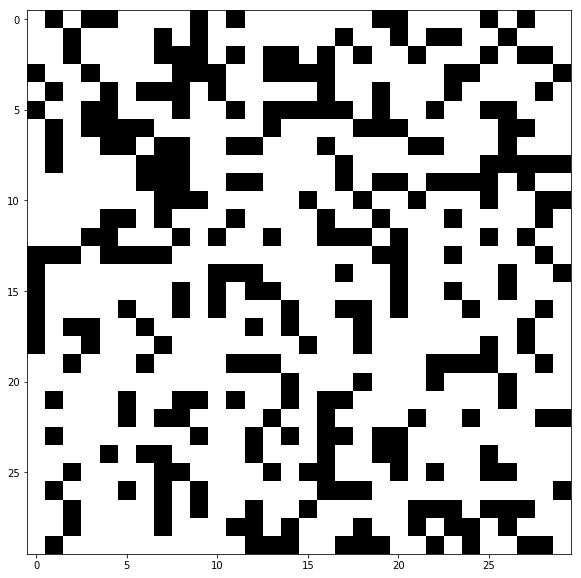

In [130]:
tiling = Tiling(_random=True)
tiling.PrepareCoverage()
#tiling.SetCoverage(testarray)
tiling.ShowCoverage()


In [131]:
tiling.Solve(testarray, tiling.columnids, tiling.rowids)

Finding the optimum tiling...
Current partial solution:  []
Array is not empty...
Working with row  1
Colums solved  [0 3 6]
Rows that solve these columns  [1 3 4 5]
Reduced array  [[0. 1. 1. 1.]
 [1. 1. 0. 1.]]
Finding the optimum tiling...
Current partial solution:  [1]
Array is not empty...
Working with row  2
Colums solved  [0 1 3]
Rows that solve these columns  [0 1]
Reduced array  []
Finding the optimum tiling...
Current partial solution:  [1, 2]
Array is not empty...
Solution does not exist!



Working with row  3
Colums solved  [0 3]
Rows that solve these columns  [1 3 5]
Reduced array  [[0. 1. 1. 1. 0.]
 [1. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1.]]
Finding the optimum tiling...
Current partial solution:  [3]
Array is not empty...
Working with row  0
Colums solved  [1 2 3]
Rows that solve these columns  [0 1]
Reduced array  [[1. 1.]]
Finding the optimum tiling...
Current partial solution:  [3, 0]
Array is not empty...
Working with row  4
Colums solved  [0 1]
Rows that solve these column

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
column_sums = np.sum(testarray[:, 1:], axis=0)
print(column_sums)
columns = np.where(column_sums == np.amin(column_sums))[0]
print(columns)
print(columns[0])

rows = np.where(testarray[:, columns[0] + 1] == 1)[0]

print(rows)

for row in rows:
    print("Looking at row %d now..." % row)
    solvedcolumns = np.where(testarray[row, 1:] == 1)[0] + 1
    print("Solved columns", solvedcolumns)

    solvingrows = np.unique(np.where(testarray[:, solvedcolumns] == 1)[0])
    print("Solving rows", solvingrows)
    
    tmp = np.delete(testarray, solvedcolumns, axis=1)
    tmp2 = np.delete(tmp, solvingrows, axis=0)
    
    solution = np.delete(np.delete(testarray, solvedcolumns, axis=1), solvingrows, axis=0)
    
print(tmp2)
print(solution)
if 0 in column_sums:
    print("Solution does not exist")

In [28]:
testarray = np.ones((2,3))
np.sum(testarray, axis=0)

array([2., 2., 2.])

In [31]:
np.sum(np.delete(testarray, [0, 1], axis=0), axis=0)

array([0., 0., 0.])

In [90]:
mylist = [0, 1, 2, 3]
print(mylist)
mylist.append(4)
print(mylist)
mylist.pop()
print(mylist)
print(mylist.empty())

[0, 1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 3]


AttributeError: 'list' object has no attribute 'empty'